# Project

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### 1. Augmentation을 적용한 데이터셋 만들기

* 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다.
* 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [2]:
# get_clip_box 함수 정의 그대로 사용
def get_clip_box(image_a, image_b):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    
    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + height // 2)
    
    return x_min, y_min, x_max, y_max

# mix_2_images 함수 정의 그대로 사용
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] 
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

# mix_2_labels 함수에서 image_a와 image_b 인자 추가
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

# cutmix 함수에서 num_classes를 인자로 받아 사용
def cutmix(image, label, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [3]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:  # 변경된 부분
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )   
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug= apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True) # 변경된 부분
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True) # 변경된 부분
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 2. 모델 만들기
* 앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [6]:
# num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [7]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


### 3. 모델 훈련하기
* sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

In [8]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy', # 'categorical_crossentropy'로 변경
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 205ms/step - loss: 2.2247 - accuracy: 0.4455 - val_loss: 3.4428 - val_accuracy: 0.1922
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 0.7350 - accuracy: 0.7983 - val_loss: 1.3519 - val_accuracy: 0.6184
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 0.2195 - accuracy: 0.9563 - val_loss: 0.9653 - val_accuracy: 0.7165
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0651 - accuracy: 0.9941 - val_loss: 0.9104 - val_accuracy: 0.7320
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0277 - accuracy: 0.9991 - val_loss: 0.9133 - val_accuracy: 0.7385
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0184 - accuracy: 0.9992 - val_loss: 0.9392 - val_accuracy: 0.7297
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0137 - accuracy: 0.9996 - val_loss: 0.9332 -

In [9]:
aug_resnet50.compile(
    loss='categorical_crossentropy', # 'categorical_crossentropy'로 변경
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [12]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 175s 226ms/step - loss: 0.0265 - accuracy: 0.9981 - val_loss: 0.8610 - val_accuracy: 0.7594
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0136 - accuracy: 0.9990 - val_loss: 0.8575 - val_accuracy: 0.7641
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0107 - accuracy: 0.9990 - val_loss: 0.8655 - val_accuracy: 0.7606
Epoch 4/20
750/750 [==============================] - 171s 228ms/step - loss: 0.0097 - accuracy: 0.9989 - val_loss: 0.8807 - val_accuracy: 0.7613
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0066 - accuracy: 0.9996 - val_loss: 0.8546 - val_accuracy: 0.7684
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0049 - accuracy: 0.9998 - val_loss: 0.8721 - val_accuracy: 0.7667
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0049 - accuracy: 0.9998 - val_loss: 0.8913 -

In [10]:
history_resnet50_aug_cutmix = aug_resnet50.fit(
    ds_train_aug_cutmix, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 211ms/step - loss: 3.8602 - accuracy: 0.2007 - val_loss: 3.2040 - val_accuracy: 0.2324
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 3.0233 - accuracy: 0.4085 - val_loss: 1.4480 - val_accuracy: 0.6056
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.7301 - accuracy: 0.4939 - val_loss: 1.5409 - val_accuracy: 0.5771
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.5580 - accuracy: 0.5528 - val_loss: 1.1081 - val_accuracy: 0.6810
Epoch 5/20
750/750 [==============================] - 156s 209ms/step - loss: 2.4169 - accuracy: 0.5905 - val_loss: 1.1680 - val_accuracy: 0.6762
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3008 - accuracy: 0.6288 - val_loss: 1.2344 - val_accuracy: 0.6572
Epoch 7/20
750/750 [==============================] - 156s 209ms/step - loss: 2.2371 - accuracy: 0.6571 - val_loss: 1.6465 -

In [13]:
history_resnet50_aug_mixup = aug_resnet50.fit(
    ds_train_aug_mixup, # augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 210ms/step - loss: 1.9863 - accuracy: 0.8099 - val_loss: 1.4445 - val_accuracy: 0.6554
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 1.8845 - accuracy: 0.8288 - val_loss: 1.4293 - val_accuracy: 0.6575
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 1.8865 - accuracy: 0.8282 - val_loss: 1.3812 - val_accuracy: 0.6681
Epoch 4/20
750/750 [==============================] - 172s 229ms/step - loss: 1.8419 - accuracy: 0.8357 - val_loss: 1.2749 - val_accuracy: 0.6912
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 1.8232 - accuracy: 0.8411 - val_loss: 1.3152 - val_accuracy: 0.6831
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 1.8024 - accuracy: 0.8441 - val_loss: 1.4573 - val_accuracy: 0.6583
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 1.7861 - accuracy: 0.8475 - val_loss: 1.3445 -

### 4. 훈련 과정 시각화하기

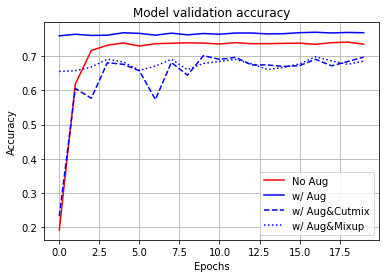

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'b--')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b:')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['No Aug', 'w/ Aug','w/ Aug&Cutmix','w/ Aug&Mixup'], loc='lower right')
plt.grid(True)
# plt.ylim(0., 0.75) 
plt.show()

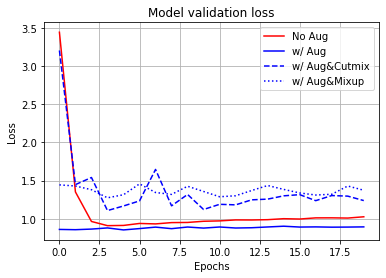

In [15]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'b--')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'b:')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['No Aug', 'w/ Aug','w/ Aug&Cutmix','w/ Aug&Mixup'], loc='upper right')
plt.grid(True)
# plt.ylim(0.8, 2.) 
plt.show()

### 5. Augmentation에 의한 모델 성능 비교
* No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교
* Augmentation 방법들의 영향도에 대해 분석해 보세요.

> epochs=20를 수행했음에도 Cutmix나 Mixup의 효용성이 나타나지 않았다.     

> Augmentation의 일반적 특징은 아래와 같으며, **실험결과와 관련된 특이사항을 추가하였습니다.**

1. 원본 데이터 (No Augmentation)
    - 장점: 데이터가 그대로 사용되므로, 모델이 데이터의 자연스러운 특성을 배울 수 있습니다.
    - 단점: 데이터가 충분하지 않을 경우 과적합(overfitting)이 발생할 가능성이 높습니다. 모델의 일반화 성능이 낮을 수 있습니다.
2. 기본 증강 (좌우 반전, 밝기 조정)
    - 장점: 간단한 증강 기법을 통해 데이터의 다양성을 높이고, 모델이 데이터의 다양한 변형에 잘 대응할 수 있게 합니다. 과적합을 방지하고 -일반화 성능을 향상시킬 수 있습니다.
    - 단점: 증강 기법이 제한적이므로 데이터 다양성의 증가가 한정적일 수 있습니다.
3. 기본 증강 + CutMix
CutMix: 두 개의 이미지를 섞는 대신, 한 이미지의 일부를 잘라내어 다른 이미지에 붙이는 기법입니다.
    - 장점: 모델이 객체의 일부분을 인식하는 데 강해집니다. 또한, CutMix는 학습 데이터를 더욱 다양하게 만들어 일반화 성능을 크게 향상시킬 수 있습니다.
    - 단점: 이미지가 불규칙하게 변형되므로 학습 초기에는 모델이 적응하는 데 시간이 걸릴 수 있습니다.
> epochs=20에도 효과가 나타나지 않았습니다.
4. 기본 증강 + MixUp
MixUp: 두 개의 이미지를 선형으로 혼합하는 기법입니다.
    - 장점: 모델이 두 이미지의 혼합된 정보를 학습하도록 유도하여, 모델이 데이터의 연속적인 변화를 더 잘 이해할 수 있게 합니다. 이로 인해 과적합이 줄어들고 일반화 성능이 향상됩니다.
    - 단점: 이미지가 자연스럽지 않을 수 있으며, 원본 이미지의 의미가 왜곡될 수 있습니다
> epochs=20에도 효과가 나타나지 않았습니다.

# 회고
* resne50모델의 층이 깊어서 그런지, 모델 작동시간이 체감될 정도로 오래 걸렸다.
* 작동시간이 오래 걸려서 epoch횟수 증대에 제한사항이 되었다.
* Cutmix와 Mixup의 효과가 epochs=20에서도 나타나지 않았다.